In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import plotly as py
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline

In [2]:
# read in the dataset

df = pd.read_csv('../data/final_labeled.csv')

In [3]:
print(df.shape)
df.head()

(38325, 10)


,id,user_name,lat,long,date,text,text_clean,n_sentence,n_words,label
0,1241152458912673794,DarkDon_,40.738154,-112.101609,2020-03-20 23:59:40+00:00,TK Kirkland's Reaction To Earthquake's Ex-Wife...,tk kirkland s reaction to earthquake ex wife o...,1,17,1
1,1241152416214474753,ReallyInID,42.242918,-112.103304,2020-03-20 23:59:30+00:00,That sound you hear is NOT an earthquake. It’s...,that sound you hear is not an earthquake it s...,2,13,1
2,1241152284827856896,folsworth,40.982162,-112.104020,2020-03-20 23:58:58+00:00,he said he stocked up on ammo cause he knew Th...,he said stocked up on ammo cause knew the big ...,2,23,1
3,1241152178695405570,Colony14,42.729481,-112.107004,2020-03-20 23:58:33+00:00,"If an earthquake separates CA, WA, and OR from...",if an earthquake separate ca wa and or from t...,1,23,1
4,1241152072818364416,MonitorSismico,41.044996,-112.103864,2020-03-20 23:58:08+00:00,"#Sismo M 4 SOUTH OF BALI, #INDONESIA. 20-03-20...",sismo m south of bali indonesia utc http...,2,13,1


In [13]:
df.isnull().sum() # --> due to stemming. dropping nulls

id               0
user_name        0
lat              0
long             0
date             0
text             0
text_clean    1219
n_sentence       0
n_words          0
label            0
dtype: int64

In [14]:
# about 3 percent of cleaned text are missing
# it could be due to non-english tweets that I did not know how to process in cleaning stage 
# will drop these rows

df.dropna(axis = 0, inplace = True)

In [16]:
# overwrite the final_labeled.csv file to store cleaner dataset

df.to_csv('../data/final_labeled.csv', index = False)

In [9]:
columns = [col for col in df.columns if col != 'label']

fig = px.histogram(df, x = 'n_words', color = 'label', marginal = 'box', hover_data = columns,
                   labels = {'n_words': 'Number of Words in a Single Tweet',
                             'label': 'Disaster (1) or Non-disaster(0)'},
                   color_discrete_sequence = ['hotpink', 'slategray'])
#pyo.iplot(fig)

fig.write_html(f'../images/word_count.html')
#fig.show() --> comment out to see the plot

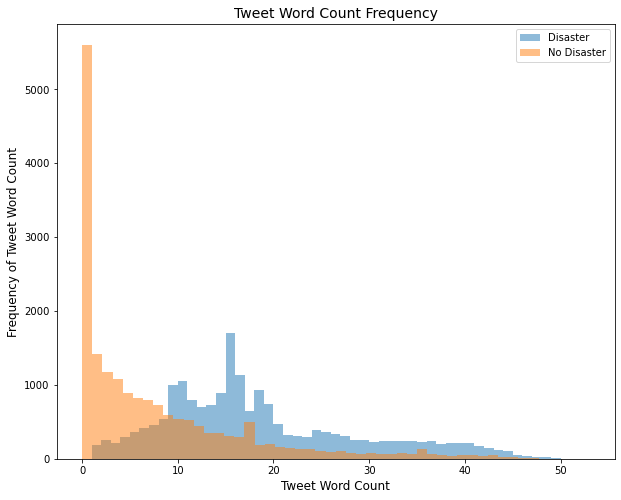

In [18]:
# distribution of word counts 

plt.figure(figsize = (10, 8))

plt.hist(df[df['label'] == 1]['n_words'], bins = 50, alpha = 0.5, label = 'Disaster')
plt.hist(df[df['label'] == 0]['n_words'], bins = 50, alpha = 0.5, label = 'No Disaster')
plt.xlabel('Tweet Word Count', size = 12)
plt.ylabel('Frequency of Tweet Word Count', size = 12)
plt.title('Tweet Word Count Frequency', size = 14)

plt.legend()
plt.savefig('../images/word_count.png');

In [10]:
fig = px.histogram(df, x = 'n_sentence', color = 'label', marginal = 'rug', hover_data = columns,
                   labels = {'n_sentence': 'Number of Sentences in a Single Tweet',
                             'label': 'Disaster (1) or Non-disaster(0)'},
                   color_discrete_sequence = ['hotpink', 'slategray'])
#pyo.iplot(fig)

fig.write_html(f'../images/sentence_count.html')
#fig.show() --> comment out to see the plot

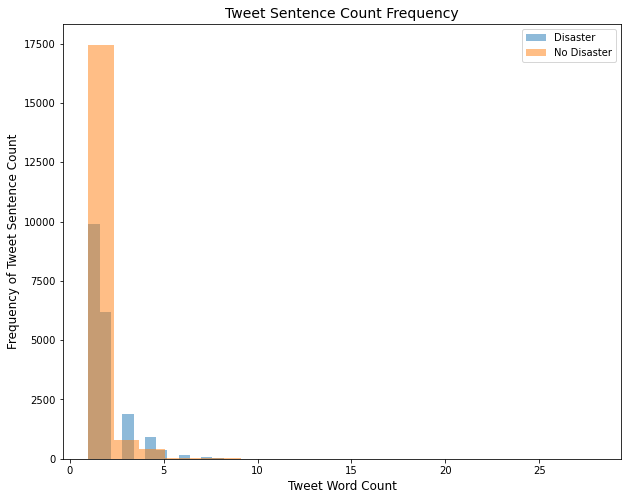

In [20]:
# distribution of sentence counts 

plt.figure(figsize = (10, 8))

plt.hist(df[df['label'] == 1]['n_sentence'], bins = 20, alpha = 0.5, label = 'Disaster')
plt.hist(df[df['label'] == 0]['n_sentence'], bins = 20, alpha = 0.5, label = 'No Disaster')
plt.xlabel('Tweet Word Count', size = 12)
plt.ylabel('Frequency of Tweet Sentence Count', size = 12)
plt.title('Tweet Sentence Count Frequency', size = 14)

plt.legend()
plt.savefig('../images/sentence_count.png');

In [21]:
# set X for vectorization

X = df['text_clean']

### CountVectorizer

In [22]:
# create custom stop words

relevant_words = ['earthquake']

# using wordcloud stopwords

stop = list(STOPWORDS) + relevant_words

In [23]:
# instantiate countvectorizer with stopwords

cvec = CountVectorizer(stop_words = stop)

In [24]:
# transform and fit on X_train, and transform X_test

X_cv = cvec.fit_transform(X)

print(X_cv.shape)

/Users/juhee/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



(38325, 49147)


In [25]:
# turn X_train to a dataframe

X_cv_df = pd.DataFrame(X_cv.toarray(), 
                       columns = cvec.get_feature_names())

In [26]:
# get count of common words

# empty dictionary

common = {}

# loop through columns

for col in X_cv_df.columns:
    
    # save sum of each column in dictionary
    common[col] = X_cv_df[col].sum()  
    
# common to dataframe sorted by highest occurance

most_common = pd.DataFrame(sorted(common.items(), key = lambda x: x[1], reverse = True))

In [27]:
# find top 20 words

most_common[:20].head(3)

,0,1
0,km,5274
1,utc,2358
2,wa,2204


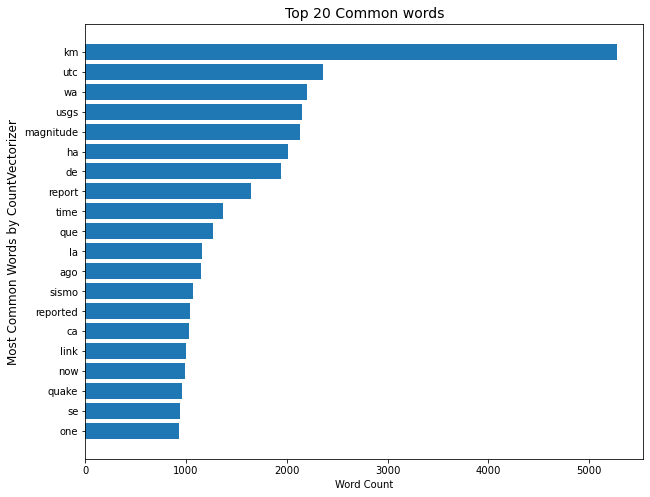

In [28]:
# plot top 20 words 

fig, ax = plt.subplots(figsize = (10, 8))

ax.barh(most_common[0][:20], most_common[1][:20], align = 'center')

ax.set_yticks(most_common.index[:20])
ax.set_yticklabels(most_common[0][:20])
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xlabel('Word Count')
ax.set_ylabel('Most Common Words by CountVectorizer', size = 12)
ax.set_title('Top 20 Common words', size = 14)

plt.savefig('../images/top20.png');

In [29]:
## find the top 20 words for disaster related tweets and non-disaster tweets

disaster = df[df['label'] == 1]['text_clean']
nondisaster = df[df['label'] == 0]['text_clean']

# instantiate another cvecs

cvec_disaster = CountVectorizer(stop_words = stop)
cvec_nondisaster = CountVectorizer(stop_words = stop)

# transform and fit

disaster = cvec_disaster.fit_transform(disaster)
nondisaster = cvec_nondisaster.fit_transform(nondisaster)

# store them in dataframes

disaster_df = pd.DataFrame(disaster.toarray(), 
                           columns = cvec_disaster.get_feature_names())

nondisaster_df = pd.DataFrame(nondisaster.toarray(),
                              columns = cvec_nondisaster.get_feature_names())

## get count of common words

# empty dictionaries

common_disaster = {}
common_nondisaster = {}

# loop through columns in sub1_df

for col in disaster_df.columns:
    
    # save sum of each column in dictionary
    common_disaster[col] = disaster_df[col].sum()  
    
# common to dataframe sorted by highest occurance

most_common_disaster = pd.DataFrame(sorted(common_disaster.items(), key = lambda x: x[1], reverse = True))

# loop through columns in sub2_df

for col in nondisaster_df.columns:
    
    # save sum of each column in dictionary
    common_nondisaster[col] = nondisaster_df[col].sum()  
    
# common to dataframe sorted by highest occurance

most_common_nondisaster = pd.DataFrame(sorted(common_nondisaster.items(), key = lambda x: x[1], reverse = True))

/Users/juhee/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



In [30]:
# top 20 words in disaster

most_common_disaster[:20].head(3)

,0,1
0,km,5264
1,utc,2358
2,usgs,2150


In [31]:
# top 20 words in non-disaster

most_common_nondisaster[:20].head(3)

,0,1
0,de,1426
1,que,1254
2,la,833


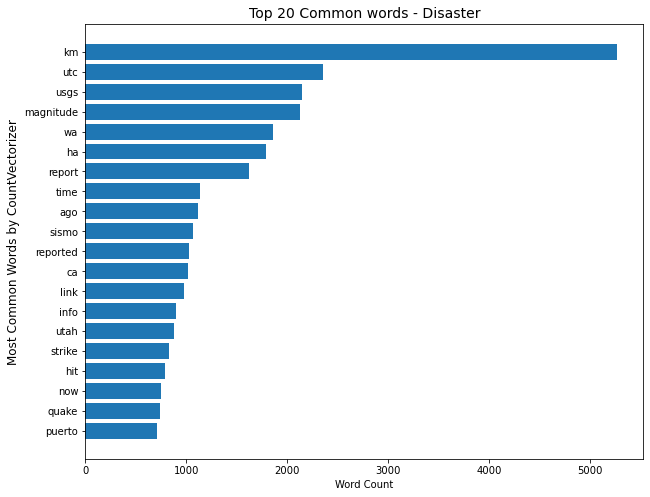

In [32]:
# plot top 20 words in disaster

fig, ax = plt.subplots(figsize = (10, 8))

ax.barh(most_common_disaster[0][:20], most_common_disaster[1][:20], align='center')

ax.set_yticks(most_common_disaster.index[:20])
ax.set_yticklabels(most_common_disaster[0][:20])
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xlabel('Word Count')
ax.set_ylabel('Most Common Words by CountVectorizer', size = 12)
ax.set_title('Top 20 Common words - Disaster', size = 14)

plt.savefig('../images/top20_disaster.png');

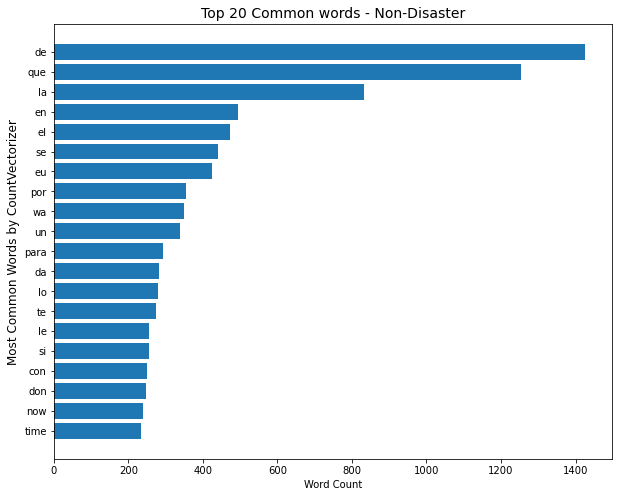

In [33]:
# plot top 20 words - non-disaster

fig, ax = plt.subplots(figsize = (10, 8))

ax.barh(most_common_nondisaster[0][:20], most_common_nondisaster[1][:20], align='center')

ax.set_yticks(most_common_nondisaster.index[:20])
ax.set_yticklabels(most_common_nondisaster[0][:20])
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xlabel('Word Count')
ax.set_ylabel('Most Common Words by CountVectorizer', size = 12)
ax.set_title('Top 20 Common words - Non-Disaster', size = 14)

plt.savefig('../images/top20_nondisaster.png');

### TfidfVectorizer

In [34]:
# instantiate countvectorizer with stopwords

tvec = TfidfVectorizer(stop_words = stop)

In [35]:
# transform and fit on X_train, and transform X_test

X_tv = tvec.fit_transform(X)

print(X_tv.shape)

/Users/juhee/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



(38325, 49147)


In [36]:
# turn X_train to a dataframe

X_tv_df = pd.DataFrame(X_tv.toarray(), 
                       columns = tvec.get_feature_names())

In [37]:
# get count of common words

# empty dictionary

common = {}

# loop through columns

for col in X_tv_df.columns:
    
    # save sum of each column in dictionary
    common[col] = X_tv_df[col].sum()  
    
# common to dataframe sorted by highest occurance

most_common = pd.DataFrame(sorted(common.items(), key = lambda x: x[1], reverse = True))

In [38]:
# find top 20 words

most_common[:20].head(3)

,0,1
0,km,909.742826
1,usgs,511.068771
2,utc,507.995593


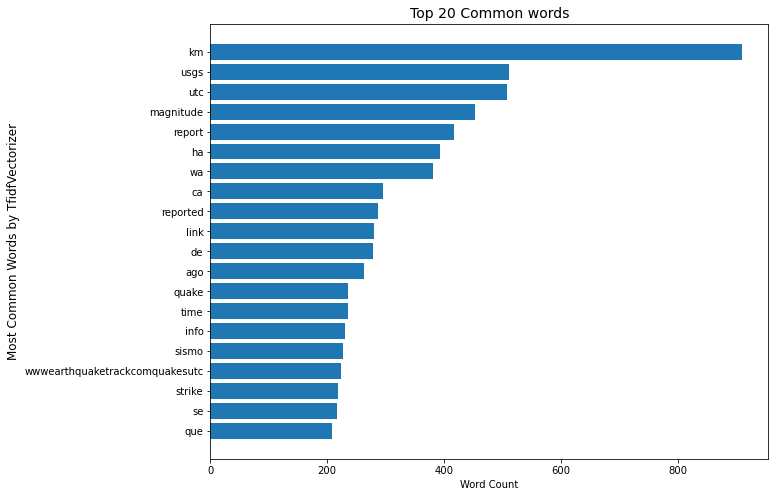

In [39]:
# plot top 20 words 

fig, ax = plt.subplots(figsize = (10, 8))

ax.barh(most_common[0][:20], most_common[1][:20], align='center')

ax.set_yticks(most_common.index[:20])
ax.set_yticklabels(most_common[0][:20])
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xlabel('Word Count')
ax.set_ylabel('Most Common Words by TfidfVectorizer', size = 12)
ax.set_title('Top 20 Common words', size = 14)

plt.savefig('../images/top20_tfidf.png');

In [40]:
## find the top 20 words for disaster related tweets and non-disaster tweets

disaster = df[df['label'] == 1]['text_clean']
nondisaster = df[df['label'] == 0]['text_clean']

# instantiate another cvecs

tvec_disaster = TfidfVectorizer(stop_words = stop)
tvec_nondisaster = TfidfVectorizer(stop_words = stop)

# transform and fit

disaster = tvec_disaster.fit_transform(disaster)
nondisaster = tvec_nondisaster.fit_transform(nondisaster)

# store them in dataframes

disaster_df = pd.DataFrame(disaster.toarray(), 
                           columns = tvec_disaster.get_feature_names())

nondisaster_df = pd.DataFrame(nondisaster.toarray(),
                              columns = tvec_nondisaster.get_feature_names())

## get count of common words

# empty dictionaries

common_disaster = {}
common_nondisaster = {}

# loop through columns in sub1_df

for col in disaster_df.columns:
    
    # save sum of each column in dictionary
    common_disaster[col] = disaster_df[col].sum()  
    
# common to dataframe sorted by highest occurance

most_common_disaster = pd.DataFrame(sorted(common_disaster.items(), key = lambda x: x[1], reverse = True))

# loop through columns in sub2_df

for col in nondisaster_df.columns:
    
    # save sum of each column in dictionary
    common_nondisaster[col] = nondisaster_df[col].sum()  
    
# common to dataframe sorted by highest occurance

most_common_nondisaster = pd.DataFrame(sorted(common_nondisaster.items(), key = lambda x: x[1], reverse = True))

/Users/juhee/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



In [41]:
# top 20 words in disaster

most_common_disaster[:20].head(3)

,0,1
0,km,791.591040
1,usgs,476.316148
2,utc,466.892574


In [42]:
# top 20 words in non-disaster

most_common_nondisaster[:20].head(3)

,0,1
0,de,193.712018
1,que,187.879904
2,la,126.855266


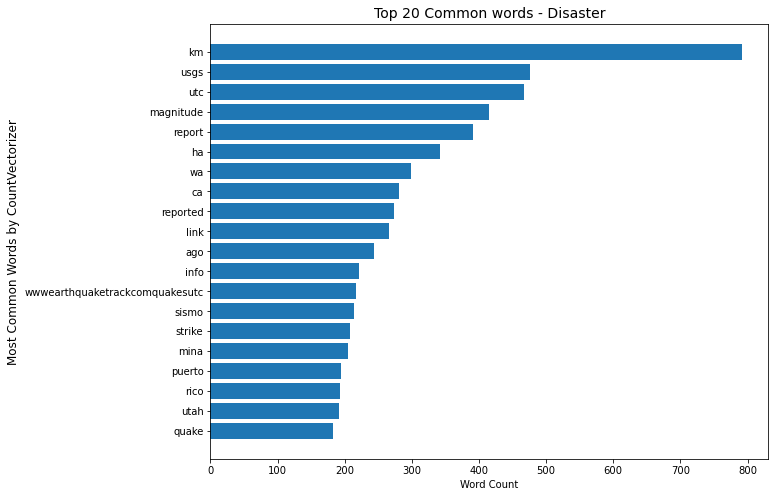

In [43]:
# plot top 20 words in disaster

fig, ax = plt.subplots(figsize = (10, 8))

ax.barh(most_common_disaster[0][:20], most_common_disaster[1][:20], align='center')

ax.set_yticks(most_common_disaster.index[:20])
ax.set_yticklabels(most_common_disaster[0][:20])
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xlabel('Word Count')
ax.set_ylabel('Most Common Words by CountVectorizer', size = 12)
ax.set_title('Top 20 Common words - Disaster', size = 14)

plt.savefig('../images/top20_disaster_t.png');

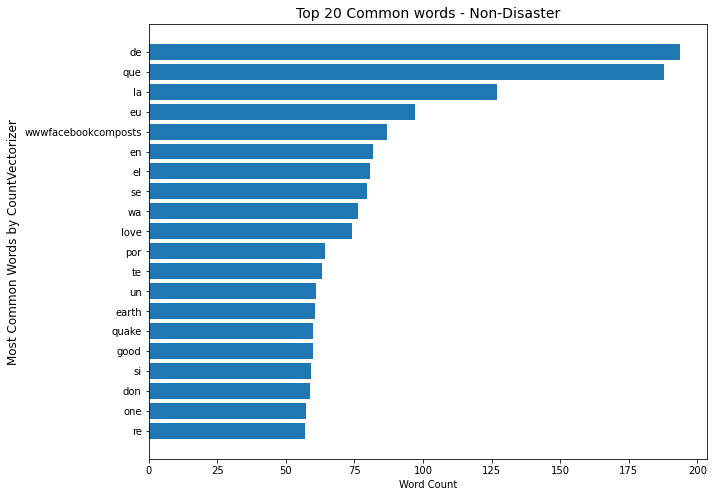

In [44]:
# plot top 20 words - non-disaster

fig, ax = plt.subplots(figsize = (10, 8))

ax.barh(most_common_nondisaster[0][:20], most_common_nondisaster[1][:20], align='center')

ax.set_yticks(most_common_nondisaster.index[:20])
ax.set_yticklabels(most_common_nondisaster[0][:20])
ax.invert_yaxis()  # labels read top-to-bottom

ax.set_xlabel('Word Count')
ax.set_ylabel('Most Common Words by CountVectorizer', size = 12)
ax.set_title('Top 20 Common words - Non-Disaster', size = 14)

plt.savefig('../images/top20_nondisaster_t.png');

### WordCloud

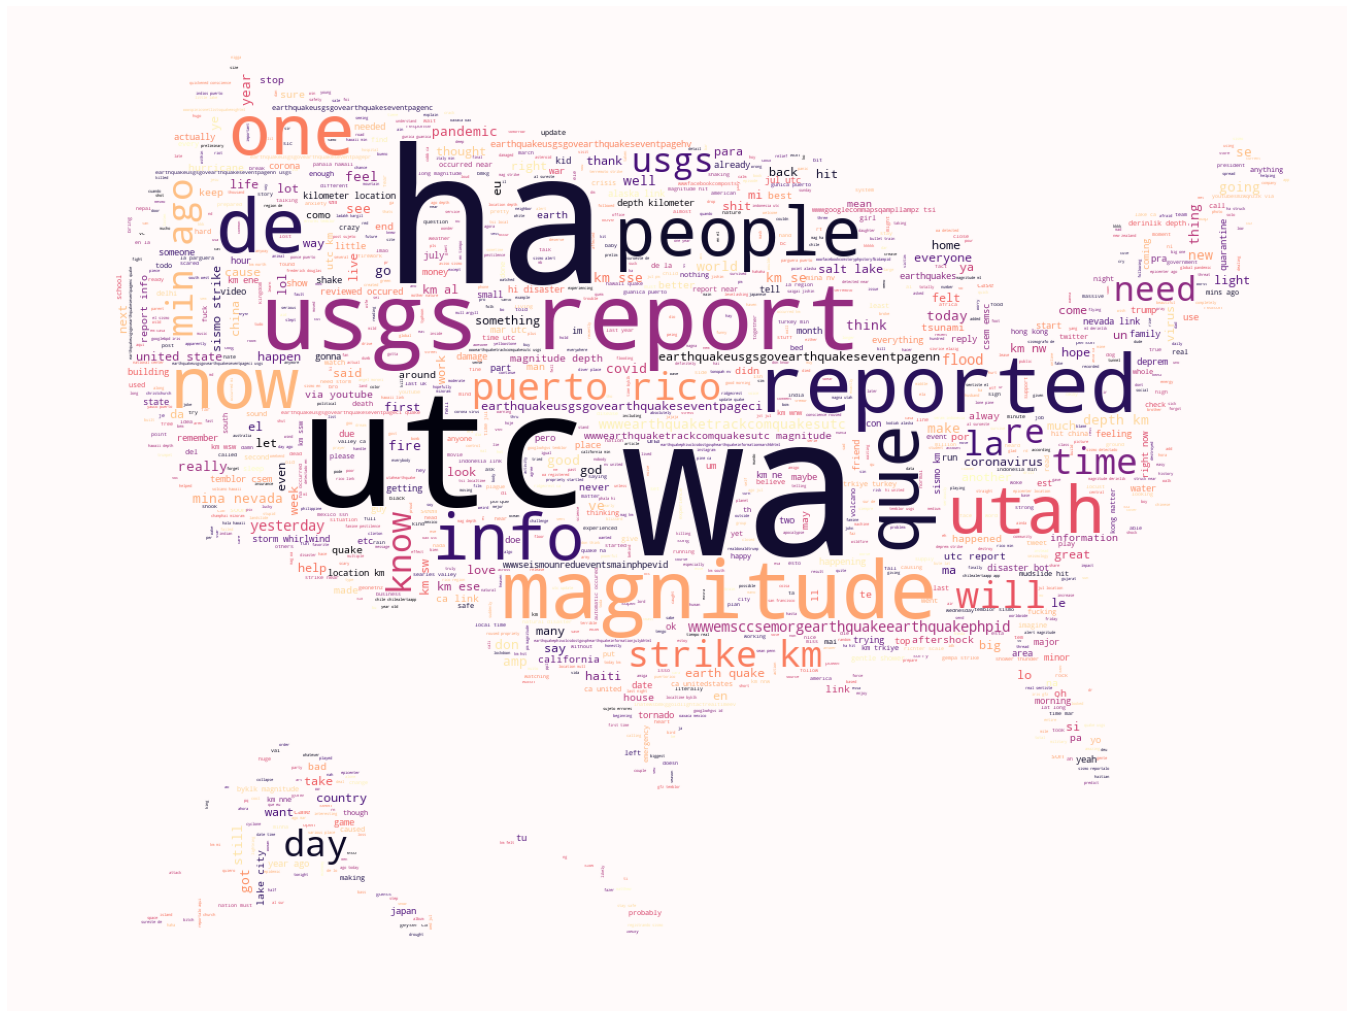

In [45]:
# Wordcloud with stopwords

mask = np.array(Image.open('../images/usa.jpg'))
txt = ' '.join(df['text_clean'].dropna())

wc = WordCloud(mask = mask, max_words = 4000, stopwords = stop, colormap = 'magma', 
               background_color = 'snow', random_state = 42).generate(txt)
plt.figure(figsize = (24, 24))

plt.imshow(wc)
plt.axis('off')
plt.title('')
plt.savefig('../images/wc_stopwords.png');

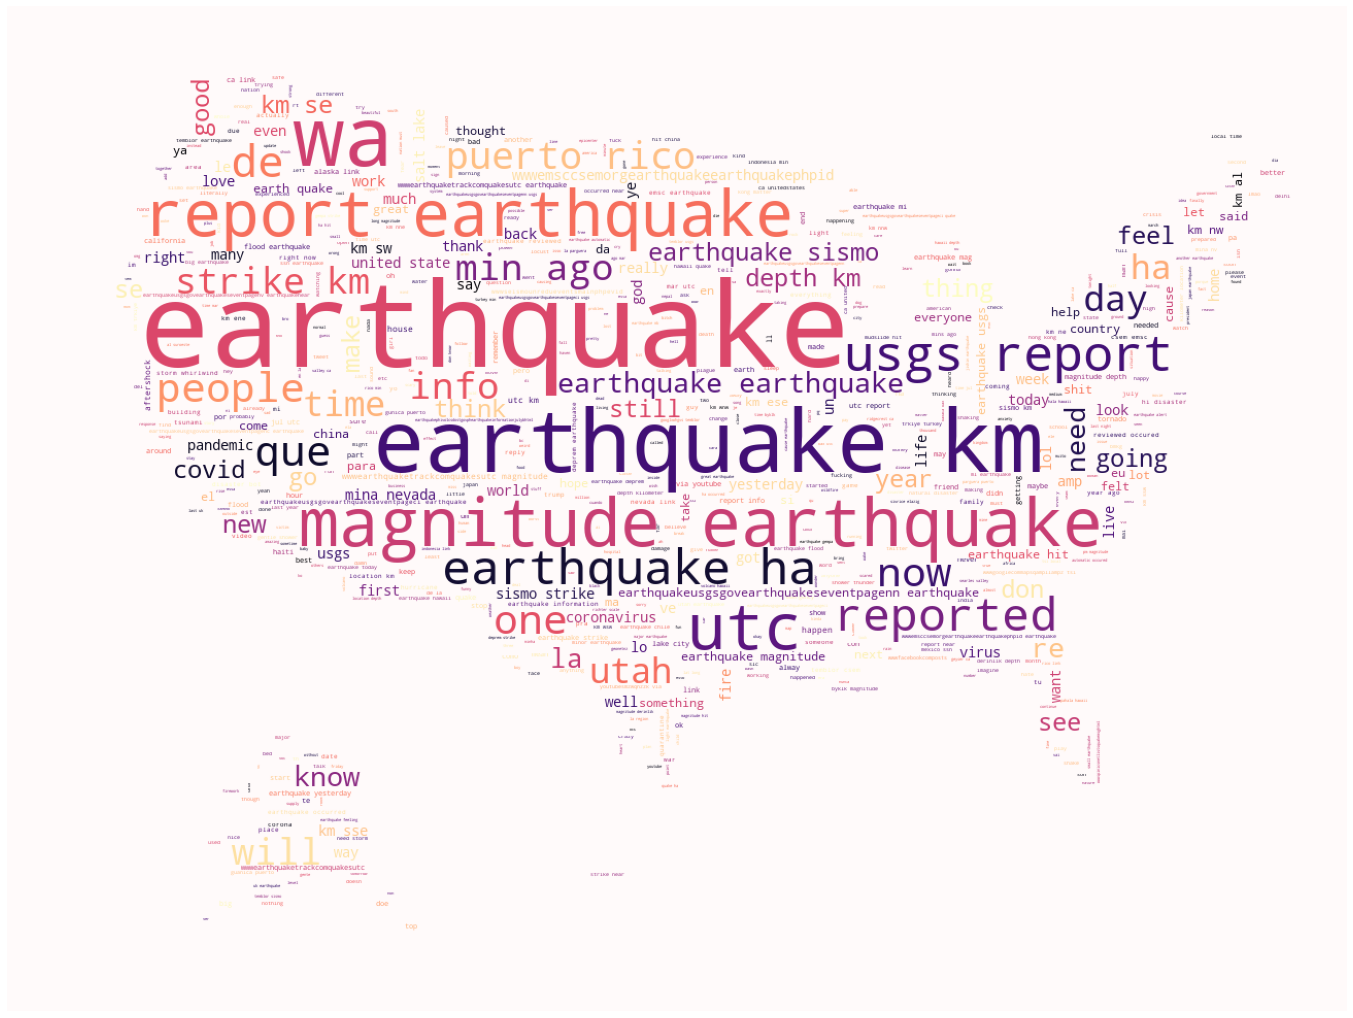

In [46]:
# Wordcloud without stopwords

mask = np.array(Image.open('../images/usa.jpg'))
txt = ' '.join(df['text_clean'].dropna())

wc = WordCloud(mask = mask, max_words = 4000, stopwords = None, colormap = 'magma', 
               background_color = 'snow', random_state = 42).generate(txt)
plt.figure(figsize = (24, 24))

plt.imshow(wc)
plt.axis('off')
plt.title('')
plt.savefig('../images/wc_nostop.png');